# Tutorial 2 AI4SD: Facial recognition for Turtles

This tutorial is inspired by the **Turtle Recall: Conservation Challenge [Zindi competition](https://zindi.africa/competitions/turtle-recall-conservation-challenge)** by DeepMind.

In this notebook, we will test the effect of transfer learning and data augmentation on a subset of this dataset, creating a model that can recognise faces of individual turtles. To do so, we will test the differences between finetuning or training from scratch a ResNet18 model in PyTorch.

The description of the dataset in this tutorial reuses most of the information in DeepMind's tutorial for the competition, but the code and tutorial is different. However, if you are interested in exploring this dataset further please check their tutorial in the competition page (in Jax). Some competitors have also released their approaches.

If you want to learn more about finetuning vision models in PyTorch I recommend you the following:
https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
We already follow most of the steps in this great PyTorch tutorial, but it shows you how to use other architectures such as Inception.

<p align="center">
  <img src="https://storage.googleapis.com/dm-turtle-recall/tutorial_images/shelfie.jpg" width="512"/>
</p>


## 1. Introduction
The aim of this competition in Zindi is to build a machine learning model to identify individual sea turtles. For each image presented, the model should output the turtle's unique ID or, if the image corresponds to a new turtle (not present in the database), identify it as a new individual. This is important for counting individuals of a species, for conservation purposes.

You can see below some of the potential challenges inherent in this dataset!
- **Face positioning**. Turtle face pictures can be taken from 3 main angles, and even within a position category like "left", head position can vary.
- **Image dimensions**. Image dimensions and aspect ratios can vary, e.g. the "top" image is in tall format whereas the other three are in wide format.
- **Image quality**. The blurriness vs. sharpness of the images can vary

Looking through other images, you'll find other sources of diversity:
- Differences in backgrounds and lighting conditions
- Extraneous objects in the image such as hands, people in the background, and tags (not related to `turtle_id`)
- Turtles can have varying amounts of sand on their head

Here is a collage of some raw, unreshaped image samples from the training dataset:

<p align="center">
  <img src="https://storage.googleapis.com/dm-turtle-recall/tutorial_images/training_image_collage.png" width="800"/>
</p>

The challenge is to be able to recognise turtle faces despite the noise and confounding factors in the images!


Some observations:
- This dataset is small, with not many images per class.
- This dataset is characterised by class imbalance, with some turtles having many more training images available than others.
This is specially true for this tutorial, because we have not considered the whole dataset, but instead a selection of around 1100 images, from the total 13000 images in the challenge.

## 2. Load the dataset

Please do not edit code cells with the following \
"### DO NOT EDIT THIS CELL" \
but add code at the required locations marked by \
"### PLEASE ADD YOUR CODE HERE"

In [ ]:
### DO NOT EDIT THIS CELL

%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import sys

**Important**: Don't forget to download the dataset from moodle and set the path for the dataset below.

This dataset contains a class per turtle, as the objective is to identify specific turtles. And it's structured such that we can use the ImageFolder dataset, rather than writing our own custom dataset. Download the data and set the path_data to the root directory of the dataset.

In [ ]:
### DO NOT EDIT THIS CELL

# mount your google drive (follow the link, allow what is needed and get the authorization code)
from google.colab import drive
from google.colab import files

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! unzip /content/drive/My

In [ ]:
### PLEASE ADD YOUR CODE HERE
path_data = 'drive/My Drive/COMP0173 - Artificial Intelligence for Sustainable Development/images/'

In [ ]:
### DO NOT EDIT THIS CELL

# I computed these before, this is the mean and std of each channel of the images, for normalisation purposes.
mean = torch.tensor([0.3788, 0.3257, 0.2735])
std = torch.tensor([0.2175, 0.1973, 0.1883])

# we resize and crop the center of the image, to have them in the same size,
# we also change the images to tensors to use torch
# The ToTensor transform should come before the Normalize transform, since the latter expects a tensor
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])



```
# This is formatted as code
```

**Question 1)** Why might we normalise image channel data to a range between [0,1], like we did in last weeks Tutorial?

Pixel values normally range between 0 and 255. CNNs are trained using Gradient Descent techniques and these large values require large gradient updates that may take a while to converge. Potentially these can even lead to issues like vanishing/exploding gradients.

**Question 2)** Instead here why do we standardise image channels rather than just normalising them between [0,1]?

Normalising values to a range does not change the shape of the underlying distribution of values. Instead by standardising (i.e. centring the new mean around 0 and scaling to achieve a standard deviation of 1) we ensure each channel (RGB) has the same distribution, and remove this bias. For instance there may be a bias towards the green channel when working with Forestry images. Or in this case our Turtle images contain a lot of brownish colours, which generally have lower blue values than red or green, and lower green than red. This mirrors the relationship in the mean values from our dataset.
This standardisation also accounts for varying lighting conditions or contrasts across the range of images in the dataset. However we do make an assumption that the underlying data generation process follows a Gaussian (Normal) distribution.

Finally these architectures like ResNet, Inception, etc that we are Transfer Learning on require standardised images and as such we must do the same.

In [ ]:
### PLEASE ADD YOUR CODE HERE

# split dataset in train and test, often datasets come with a specific split, but this is not the case here
# we select 10% at random for our test set
def train_val_dataset(dataset, val_split=0.1):
    ### Split by index, then create a joint dictionary with keys train and val that use the PyTorch function Subset to assign the data by index
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

# load your dataset
dataset = torchvision.datasets.ImageFolder(path_data, transform=transform)

datasets = train_val_dataset(dataset)
print(f"We have {len(datasets['train'])} training turtle images.")
print(f"We have {len(datasets['val'])} test turtle images.")

We have 459 training turtle images.
We have 52 test turtle images.


In [ ]:
### PLEASE ADD YOUR CODE HERE

### Create the dataloaders, this will be used when loading each batch and will apply the transforms we set before
### The dataloader is a dictionary with two keys (train and val)
### Also define a batch size!
batch_size = 32
dataloaders_dict = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

In [ ]:
### DO NOT EDIT THIS CELL

# iterator for the data loader
# labels correspond to turtle_ids

data_iter = iter(dataloaders_dict['train'])
images, labels = next(data_iter)

Let's see how the turtles look like! You can change the id below to see different turtles.

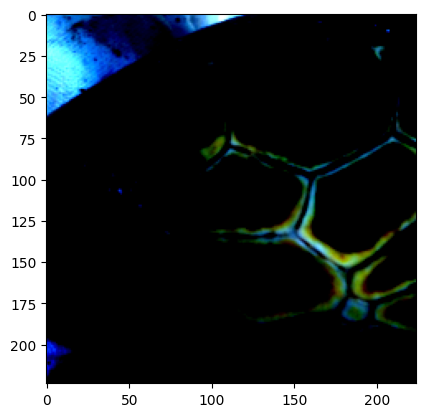

In [ ]:
# You can change the 5 index below to see different turtles!
plt.imshow(images[5].permute(1, 2, 0))
# Note we normalised the data before so the turtles don't look exactly as they normally do!

**Question 3)** How many dimensions are there of the output tensor from the dataloader, and what does each dimension relate to?

It is a 4D tensor relating to (batch, channel, height, width) which is what PyTorch requires

For other libraries this can be different: \
Matplotlib and other image processing libraries are often (height, width, channel) \
JAX (Flax) is (batch, height, width, channel)

Make sure you check documentation when working with different frameworks!

## 3. Create the predictive model
Since we want to match images to labels (classes), we are dealing with an **image classification** problem. Image classification is generally most successfully approached using deep **convolutional neural networks** (CNNs).

### 3.1 Convolutional neural networks

At the highest level, CNNs take images as inputs and return probabilities that the image belongs to each of the possible classes.

In slightly more detail, CNNs hierarchically extract features from images using convolutional layers, which are usually followed by pooling layers that summarise the information in the extracted feature maps:
- Lower CNN layers capture low-level image features (edges, blobs)
- Layers deeper in the CNN capture higher-level features and objects (scale patterns, turtle eyes)
- Fully connected layers can then consolidate these extracted patterns and objects

<p align="center">
  <img src="https://storage.googleapis.com/dm-turtle-recall/tutorial_images/cnn.png" width="1100"/>
</p>

We won't go into a detailed explanation of CNNs here; if you'd like to learn more about their inner workings, we recommend [CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/).

### 3.2 Transfer learning for image classification

To approach this turtle face classification problem, we could specify a CNN architecture, initialise it, and proceed to train its parameters from scratch.

An alternative approach, which is very popular in the computer vision (image processing) world, is called **transfer learning**:
- Instead of training your model on your task from scratch, you first identify a model that has been **pre-trained** on some other image task
- You can then adapt it (**"fine-tune"** it) to your specific task

This is a popular approach because it often gets you two advantages:
- **Improved performance**. The pre-training does a lot of the heavy lifting of learning to understand images. The most popular pre-trained models were trained on huge datasets for a long period of time, and you can simply piggy back on what they've learned.
  - The features that these models learn are often reusable for many image-related tasks.
  - This is because lower level visual features such as edges, colour blobs, simple composite shapes etc. are pervasive regardless of the specifics of the image task.
- **Lower data and computational requirements**. Using a pre-trained model often means you don't need as much training data, time, or compute to reach a certain level of performance.

There are plenty of pre-trained computer vision models available, the most popular probably being VGG, ResNet, EfficientNet, etc.

### 3.3 Finetuning ResNet18

Here, we will make use of a pre-trained ResNet18 model made available in PyTorch.

Specifically, in this tutorial we will take a deeper look at how to finetune and feature extract the torchvision models, all of which have been pretrained on the 1000-class Imagenet dataset. This tutorial will give an indepth look at how to work with several modern CNN architectures, and will build an intuition for finetuning any PyTorch model. Since each model architecture is different, there is no boilerplate finetuning code that will work in all scenarios. Rather, the researcher must look at the existing architecture and make custom adjustments for each model.

In this document we will perform two types of transfer learning: finetuning and feature extraction. In finetuning, we start with a pretrained model and update all of the model’s parameters for our new task, in essence retraining the whole model. In feature extraction, we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer. For more technical information about transfer learning see here and here.

In general both transfer learning methods follow the same few steps:
1. Initialize the pretrained model
2. Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
3. Define for the optimization algorithm which parameters we want to update during training
4. Run the training step




### 4. Tutorial

The model_name input is the name of the model you wish to use and must be selected from this list:
[resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: num_classes is the number of classes in the dataset, batch_size is the batch size used for training and may be adjusted according to the capability of your machine, num_epochs is the number of training epochs we want to run, and feature_extract is a boolean that defines if we are finetuning or feature extracting. If feature_extract = False, the model is finetuned and all model parameters are updated. If feature_extract = True, only the last layer parameters are updated, the others remain fixed.

In [ ]:
### DO NOT EDIT THIS CELL

model_name = 'resnet'

# Number of classes in the dataset
num_classes = len(dataset.classes)
print(f"We have {num_classes} unique turtles!")

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

We have 50 unique turtles!


#### 4.1 Model training and validation
The train_model function handles the training and validation of a given model. As input, it takes a PyTorch model, a dictionary of dataloaders, a loss function, an optimizer, a specified number of epochs to train and validate for, and a boolean flag for when the model is an Inception model. The is_inception flag is used to accomodate the Inception v3 model, as that architecture uses an auxiliary output and the overall model loss respects both the auxiliary output and the final output, as described here. The function trains for the specified number of epochs and after each epoch runs a full validation step. It also keeps track of the best performing model (in terms of validation accuracy), and at the end of training returns the best performing model. After each epoch, the training and validation accuracies are printed.

In [ ]:
### PLEASE ADD YOUR CODE HERE

def train_model(model, dataloaders, loss_func, optimiser, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # we send these to device (the cpu/gpu/tpu)
                labels = labels.to(device)

                ### Zero the parameter gradients for the optimiser
                optimiser.zero_grad()

                # Forward pass, only track history if in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        ### Pass dataloader inputs through the model, then the two outputs and labels through loss function
                        ### Add losses together with a weighting on loss 2
                        ### Hint Inception has two outputs to workaround a vanishing gradient problem, if stuck https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = loss_func(outputs, labels)
                        loss2 = loss_func(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        ### Eval phase has only one output
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)

                    ### Take the indices from torch.max as the predictions
                    _, preds = torch.max(outputs, 1)

                    ### Backward pass + optimise step only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimiser.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

This helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting. By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. This will make more sense later.

In [ ]:
### DO NOT EDIT THIS CELL

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#### 4.2 Initialise and reshape the networks
Now to the most interesting part. Here is where we handle the reshaping of each network. Note, this is not an automatic procedure and is unique to each model. Recall, the final layer of a CNN model, which is often times an FC layer, has the same number of nodes as the number of output classes in the dataset. Since all of the models have been pretrained on Imagenet, they all have output layers of size 1000, one node for each class. The goal here is to reshape the last layer to have the same number of inputs as before, AND to have the same number of outputs as the number of classes in the dataset. In the following sections we will discuss how to alter the architecture of each model individually. But first, there is one important detail regarding the difference between finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the last layer, or in other words, we only want to update the parameters for the layer(s) we are reshaping. Therefore, we do not need to compute the gradients of the parameters that we are not changing, so for efficiency we set the .requires_grad attribute to False. This is important because by default, this attribute is set to True. Then, when we initialize the new layer and by default the new parameters have .requires_grad=True so only the new layer’s parameters will be updated. When we are finetuning we can leave all of the .required_grad’s set to the default of True.


In [ ]:
### DO NOT EDIT THIS CELL

def initialise_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialise these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialise the model for this run
model_ft, input_size = initialise_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Resnet was introduced in the paper Deep Residual Learning for Image Recognition. There are several variants of different sizes, including Resnet18, Resnet34, Resnet50, Resnet101, and Resnet152, all of which are available from torchvision models. Here we use Resnet18, as our dataset is small. When we print the model, we see that the last layer is a fully connected layer as shown below: (fc): Linear(in_features=512, out_features=1000, bias=True)

Thus, we must reinitialize model.fc to be a Linear layer with 512 input features and 2 output features with:

In [ ]:
model_ft.fc = nn.Linear(512, num_classes)

Notice, many of the models have similar output structures, but each must be handled slightly differently. Also, check out the printed model architecture of the reshaped network and make sure the number of output features is the same as the number of classes in the dataset.

#### 4.3 Training

In [ ]:
### DO NOT EDIT THIS CELL

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now that the model structure is correct, the final step for finetuning and feature extracting is to create an optimizer that only updates the desired parameters. Recall that after loading the pretrained model, but before reshaping, if feature_extract=True we manually set all of the parameter’s .requires_grad attributes to False. Then the reinitialized layer’s parameters have .requires_grad=True by default. So now we know that all parameters that have .requires_grad=True should be optimized. Next, we make a list of such parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When finetuning, this list should be long and include all of the model parameters. However, when feature extracting this list should be short and only include the weights and biases of the reshaped layers.

In [ ]:
### DO NOT EDIT THIS CELL

model_ft = model_ft.to(device)

#  Gather the parameters to be optimised/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


Finally, the last step is to setup the loss for the model, then run the training and validation function for the set number of epochs. Notice, depending on the number of epochs this step may take a while on a CPU. Also, the default learning rate is not optimal for all of the models, so to achieve maximum accuracy it would be necessary to tune for each model separately.

In [ ]:
### PLEASE ADD YOUR CODE HERE

# Setup the loss func
import time
import copy

### What is a good loss function for a multi-class classification task and why?
loss_function = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, loss_function, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/19
----------
train Loss: 3.9541 Acc: 0.0479
val Loss: 3.9495 Acc: 0.0385

Epoch 1/19
----------
train Loss: 3.7750 Acc: 0.0763
val Loss: 3.8888 Acc: 0.0769

Epoch 2/19
----------
train Loss: 3.6682 Acc: 0.1068
val Loss: 3.8634 Acc: 0.0385

Epoch 3/19
----------
train Loss: 3.5775 Acc: 0.1394
val Loss: 3.8618 Acc: 0.0192

Epoch 4/19
----------
train Loss: 3.4950 Acc: 0.1460
val Loss: 3.8174 Acc: 0.0577

Epoch 5/19
----------
train Loss: 3.3985 Acc: 0.1612
val Loss: 3.7843 Acc: 0.0769

Epoch 6/19
----------
train Loss: 3.3140 Acc: 0.2309
val Loss: 3.7537 Acc: 0.1154

Epoch 7/19
----------
train Loss: 3.2383 Acc: 0.2571
val Loss: 3.7317 Acc: 0.1346

Epoch 8/19
----------
train Loss: 3.1582 Acc: 0.2963
val Loss: 3.7441 Acc: 0.1154

Epoch 9/19
----------
train Loss: 3.0828 Acc: 0.3094
val Loss: 3.6809 Acc: 0.1154

Epoch 10/19
----------
train Loss: 2.9965 Acc: 0.3551
val Loss: 3.6680 Acc: 0.1346

Epoch 11/19
----------
train Loss: 2.9329 Acc: 0.3529
val Loss: 3.6232 Acc: 0.1346

Ep

#### 4.4 Comparison with model trained from scratch
Just for fun, lets see how the model learns if we do not use transfer learning. The performance of finetuning vs. feature extracting depends largely on the dataset but in general both transfer learning methods produce favorable results in terms of training time and overall accuracy versus a model trained from scratch.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/19
----------
train Loss: 3.9860 Acc: 0.0218
val Loss: 3.8740 Acc: 0.0385

Epoch 1/19
----------
train Loss: 3.7670 Acc: 0.0566
val Loss: 3.9194 Acc: 0.0385

Epoch 2/19
----------
train Loss: 3.6947 Acc: 0.0719
val Loss: 3.9165 Acc: 0.0192

Epoch 3/19
----------
train Loss: 3.6524 Acc: 0.0937
val Loss: 3.9234 Acc: 0.0385

Epoch 4/19
----------
train Loss: 3.6124 Acc: 0.0784
val Loss: 3.9299 Acc: 0.0385

Epoch 5/19
----------
train Loss: 3.5827 Acc: 0.0959
val Loss: 3.8950 Acc: 0.0577

Epoch 6/19
----------
train Loss: 3.5403 Acc: 0.0959
val Loss: 3.9616 Acc: 0.0385

Epoch 7/19
----------
train Loss: 3.4986 Acc: 0.1002
val Loss: 3.9515 Acc: 0.0385

Epoch 8/19
----------
train Loss: 3.4460 Acc: 0.1438
val Loss: 3.9208 Acc: 0.0577

Epoch 9/19
----------
train Loss: 3.4148 Acc: 0.1394
val Loss: 3.9803 Acc: 0.0385

Epoch 10/19
----------
train Loss: 3.3611 Acc: 0.1438
val Loss: 3.8825 Acc: 0.0385

Epoch 11/19
----------
train Loss: 3.3278 Acc: 0.1525
val Loss: 3.9412 Acc: 0.0385

Ep

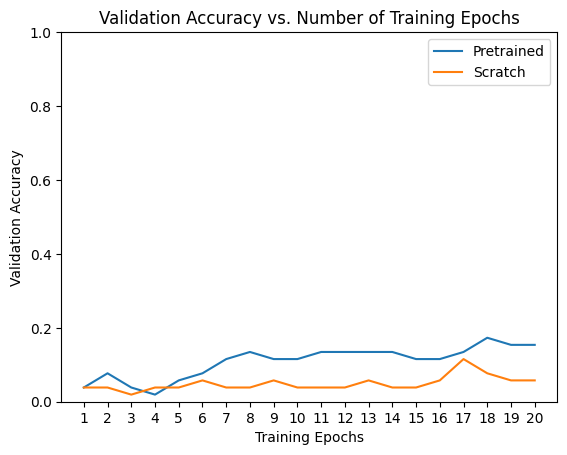

In [ ]:
### PLEASE ADD YOUR CODE HERE

### Initialise the non-pretrained version of the model used for this run using previous functions we have written, what needs to be changed?
scratch_model,_ = initialise_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
### Send model to device
scratch_model = scratch_model.to(device)
### Add SGD optimiser with learning rate 0.001 and momentum 0.9
scratch_optimiser = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
### What loss function?
scratch_loss_func = nn.CrossEntropyLoss()

_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_loss_func, scratch_optimiser, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

As you can see pretrained networks reach much better performance. We leave it up to you to test feature_extract = False, finetuning the whole model, instead of only the last layer.

Note that neither of the two approaches reach very good results, but keep in mind that we are using a tiny subset of the whole dataset. Specifically, we are using around 1000 turtle images, whereas the original dataset has around 14000. Note as well we are not running the training for too long (just 20 epochs) and we are not using very deep architectures. If you wanted you could check what happens if you go from ResNet18 to ResNet50.

## More information
If you want to test other ways to approach this challenge I recommend you the following tutorial with the same dataset using contrastive learning: https://datasciencecastnet.home.blog/2022/02/18/turtle-recall-a-contrastive-learning-approach/

The tutorial is in Jax: https://colab.research.google.com/drive/1AZkjlJ3oPUL-nZ03PU4d_jQL2yiKNHJp?usp=sharing#scrollTo=on6iin47-F1z